- Fusion avec extraction de caractéristiques unimodales
  - Extraire séparément les caractéristiques textuelles et visuelles à partir des deux meilleurs modèles obtenus dans les parties précédentes meilleurs.
  - Concaténer les caractéristiques extraites pour créer une représentation commune des données.
  - Ajouter des couches denses pour la classification multi-label finale.
- Entraînement conjoint des connées textuelles et visuelles
  - Utiliser l’architecture des deux meilleurs modèles choisis précédemment et optimiser l’apprentissage en entraînant le modèle sur les deux modalités simultanément.
  - Expérimenter avec différents hyperparamètres (taux d’apprentissage, architecture, régularisation).
  - Évaluer les performances et analyser les résultats.
- Comparaison des performances et choix du modèle final
  - Comparer les performances du modèle multimodal avec celles des modèles unimodaux (images seule, textes seul).
- Justifier le choix du modèle final.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 663.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
import nltk

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score, average_precision_score

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/IA/projet_final/data/data_multimodal_class/train_split.csv')
test_df = pd.read_csv('/content/drive/MyDrive/IA/projet_final/data/data_multimodal_class/test_split.csv')
val_df = pd.read_csv('/content/drive/MyDrive/IA/projet_final/data/data_multimodal_class/val_split.csv')

In [6]:
def convert_to_list(labels):
    return [label.split(' ') for label in labels]

train_df['Labels'] = convert_to_list(train_df['Labels'])
val_df['Labels'] = convert_to_list(val_df['Labels'])
test_df['Labels'] = convert_to_list(test_df['Labels'])

In [7]:
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_df['Labels'])
val_labels   = mlb.transform(val_df['Labels'])
test_labels  = mlb.transform(test_df['Labels'])

In [8]:
# get number of classes
classes_nbr = (len(mlb.__dict__['classes_']))
classes_nbr

16

In [9]:
mlb.__dict__['classes_']

array(['10', '11', '13', '15', '16', '17', '18', '19', '2', '3', '4', '5',
       '6', '7', '8', '9'], dtype=object)

In [10]:
def process_labels(labels):
    return tf.convert_to_tensor(labels, dtype=tf.float32)

In [11]:
def load_image(image_path, base_dir):
    # Construct the full image path using a base directory
    full_path = tf.strings.join([base_dir, image_path])

    image = tf.io.read_file(full_path)  # Now reads from the full path
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize for model input
    image = image / 255.0  # Normalize
    return image

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [14]:
def preprocess_text(sentence: str) -> str:

    sentence = sentence.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [15]:
X_train = train_df["Caption"].apply(preprocess_text).tolist()
X_test = test_df["Caption"].apply(preprocess_text).tolist()
X_val = val_df["Caption"].apply(preprocess_text).tolist()

In [16]:
# Fonction pour aplatir les embeddings (moyenne des vecteurs mots)
def flatten_embedding(embedding):
    if len(embedding) == 0:
        return np.zeros(50)  # Si le texte est vide, retourne un vecteur nul
    return np.mean(embedding, axis=0)  # Moyenne des vecteurs mots

Tokénisation

In [17]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

In [18]:
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)
X_val = word_tokenizer.texts_to_sequences(X_val)

In [19]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

4210

In [20]:
MAX_NB_WORDS = vocab_length
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 50
NUM_CLASSES = 16

In [21]:
# Padding
train_padded = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
val_padded   = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
test_padded  = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [22]:
AUTOTUNE = tf.data.AUTOTUNE  # Automatically chooses the best prefetch size

train_dir = '/content/drive/MyDrive/IA/projet_final/data/data_multimodal_class/train_images/'
val_dir = '/content/drive/MyDrive/IA/projet_final/data/data_multimodal_class/val_images/'
test_dir = '/content/drive/MyDrive/IA/projet_final/data/data_multimodal_class/test_images/'

train_ds = tf.data.Dataset.zip((
    (
      tf.data.Dataset.from_tensor_slices(train_padded),
      tf.data.Dataset.from_tensor_slices(train_df['ImageID']).map(lambda x: load_image(x, train_dir), num_parallel_calls=AUTOTUNE)
    ),
    tf.data.Dataset.from_tensor_slices(process_labels(train_labels)),
)).batch(32).prefetch(1)

val_ds = tf.data.Dataset.zip((
    (
        tf.data.Dataset.from_tensor_slices(val_padded),
      tf.data.Dataset.from_tensor_slices(val_df['ImageID']).map(lambda x: load_image(x, val_dir), num_parallel_calls=AUTOTUNE)
    ),
    tf.data.Dataset.from_tensor_slices(process_labels(val_labels))
)).batch(32).prefetch(1)

test_ds = tf.data.Dataset.zip((
    (
        tf.data.Dataset.from_tensor_slices(test_padded),
        tf.data.Dataset.from_tensor_slices(test_df['ImageID']).map(lambda x: load_image(x, test_dir), num_parallel_calls=AUTOTUNE)
    ),
    tf.data.Dataset.from_tensor_slices(process_labels(test_labels))
)).batch(32).prefetch(1)

In [23]:
@tf.function(experimental_relax_shapes=True)
def f1_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Seuil de classification (0.5 pour sigmoid)
    tp = tf.reduce_sum(y_true * y_pred)  # Vrais positifs
    precision = tp / (tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())
    recall = tp / (tf.reduce_sum(y_true) + tf.keras.backend.epsilon())
    return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

In [24]:
def model_performance(model_name, history):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create side-by-side subplots

    # Plot F1_score
    axes[0].plot(history.history['f1_metric'], label='Train F1_score', marker='o')
    axes[0].plot(history.history['val_f1_metric'], label='Validation F1_score', marker='o')
    axes[0].set_title(f'{model_name} - F1_score')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('F1_score')
    axes[0].legend()
    axes[0].grid()

    # Plot Loss
    axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='o')
    axes[1].set_title(f'{model_name} - Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()

In [25]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(classes_nbr), yticklabels=range(classes_nbr))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

###Fusion avec extraction de caractéristiques unimodales

- Extraire séparément les caractéristiques textuelles et visuelles à partir des deux meilleurs modèles obtenus dans les parties précédentes meilleurs.
- Concaténer les caractéristiques extraites pour créer une représentation commune des données.
- Ajouter des couches denses pour la classification multi-label finale.

In [30]:
text_model = load_model("/content/drive/MyDrive/IA/projet_final/model/hybrid_lstm_cnn_model.h5")

vgg2_model = load_model("/content/drive/MyDrive/IA/projet_final/model/vgg2_model.h5")

# Extraire les caractéristiques des modèles
# Pour le modèle textuel
text_features = text_model.layers[-3].output  # Juste avant la couche Dense (Dense 128)

# Pour le modèle visuel (VGG19 pré-entraîné avec fine-tuning partiel)
block5_pool_layer_index = None
for index, layer in enumerate(vgg2_model.layers):
    if layer.name == 'block5_pool':
        block5_pool_layer_index = index
        break

# If the layer is found, proceed with extracting the features
if block5_pool_layer_index is not None:
    image_features = vgg2_model.layers[block5_pool_layer_index].output  # Get output from the layer
    image_features = layers.GlobalAveragePooling2D()(image_features)  # Reduce spatial dimension
else:
    print("Layer 'block5_pool' not found in the model.")

# Fusionner les deux types de caractéristiques
merged_features = layers.concatenate([text_features, image_features])

# Ajouter des couches denses pour la classification finale
x = layers.Dense(256, activation='relu', name='dense_1')(merged_features)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(classes_nbr, activation='sigmoid', name='output_layer')(x)  # Pour la classification multi-label

# 6. Créer le modèle final
final_model = Model(inputs=[text_model.input, vgg2_model.input], outputs=output)

# Compiler le modèle final
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_metric])

# Afficher le résumé du modèle final
final_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv4 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 28, 28, 256)    │              0 │ block3_conv4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 28, 28, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv4 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 30)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool          

 Total params: 20,524,372 (78.29 MB)

 Trainable params: 7,579,412 (28.91 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

In [31]:
# Entraîner le modèle final
history_final_model = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=32
)

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.4922 - f1_metric: 0.4770 - loss: 0.2143 - val_accuracy: 0.5878 - val_f1_metric: 0.6367 - val_loss: 0.1679
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.6715 - f1_metric: 0.7133 - loss: 0.1352 - val_accuracy: 0.5983 - val_f1_metric: 0.6584 - val_loss: 0.1609
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.6928 - f1_metric: 0.7461 - loss: 0.1223 - val_accuracy: 0.6046 - val_f1_metric: 0.6680 - val_loss: 0.1620
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 403s 1s/step - accuracy: 0.7097 - f1_metric: 0.7721 - loss: 0.1134 - val_accuracy: 0.6084 - val_f1_metric: 0.6741 - val_loss: 0.1618
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.7215 - f1_metric: 0.7865 - loss: 0.1083 - val_accuracy: 0.5983 - val_f1_metric: 0.6664 - val_loss: 0.1641
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.7251 - f1_metric: 0.7969 - loss: 0.1039 - val_accuracy: 0.5975 - val

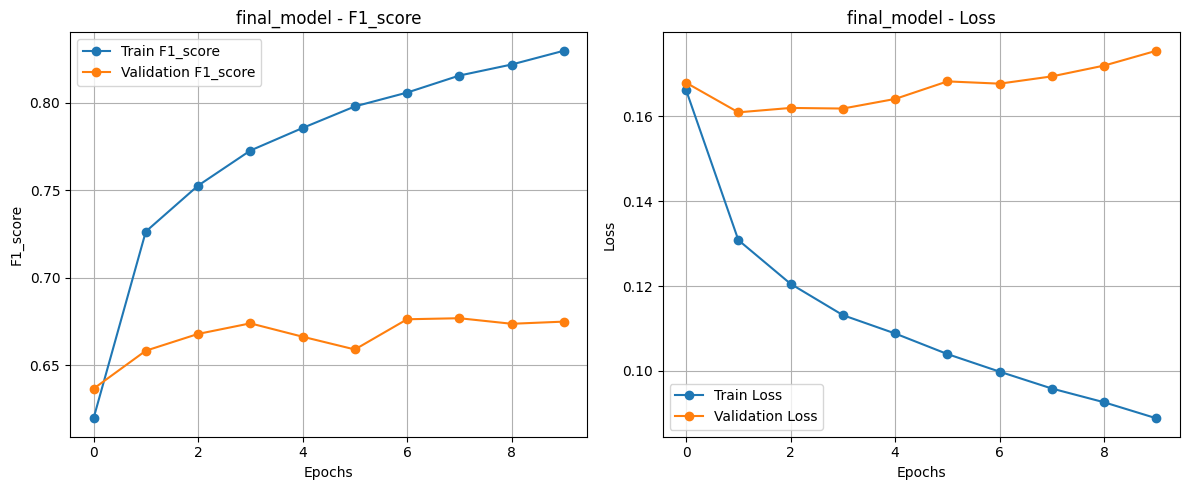

In [32]:
model_performance("final_model", history_final_model)

75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 781ms/step


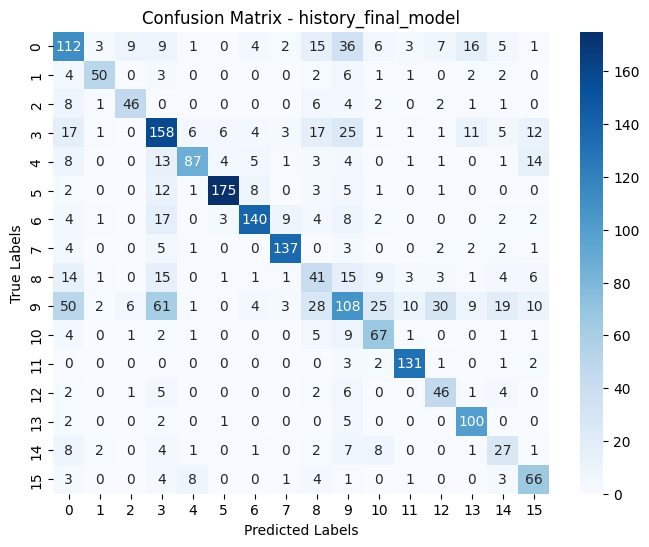

In [37]:
y_pred_multi = final_model.predict(test_ds)
y_pred_multi = (y_pred_multi > 0.5).astype(int)

plot_confusion_matrix(test_labels, y_pred_multi, "history_final_model")

###Entraînement conjoint des connées textuelles et visuelles
  

- Utiliser l’architecture des deux meilleurs modèles choisis précédemment et optimiser l’apprentissage en entraînant le modèle sur les deux modalités simultanément.
- Expérimenter avec différents hyperparamètres (taux d’apprentissage, architecture, régularisation).
- Évaluer les performances et analyser les résultats.


- VGG

In [38]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler toutes les couches du modèle pré-entraîné
base_model.trainable = False

# Ajout d'une nouvelle tête de classification
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
out_image = layers.Dense(classes_nbr, activation="sigmoid")(x)

# Modèle initial avec uniquement la nouvelle tête entraînable
vgg2_model = Model(inputs=base_model.input, outputs=out_image)

vgg2_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 23,254,352 (88.71 MB)

 Trainable params: 3,229,968 (12.32 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [41]:
# Compilation et premier entraînement sur la nouvelle tête
vgg2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_metric])

image_train_ds = train_ds.map(lambda data, labels: (data[1], labels))
image_val_ds = val_ds.map(lambda data, labels: (data[1], labels))

vgg2_model.fit(image_train_ds, epochs=5, validation_data=image_val_ds)  #Entraîner d'abord la nouvelle tête

# Fine-Tuning Partiel : dégeler certaines couches du VGG19 (les dernières)
for layer in base_model.layers[-4:]:  #Dégeler uniquement les 4 dernières couches
    layer.trainable = True

# Réentraîner le modèle avec un apprentissage plus lent (learning rate réduit)
vgg2_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=[f1_metric])

Epoch 1/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 327s 935ms/step - f1_metric: 0.1884 - loss: 0.2925 - val_f1_metric: 0.3022 - val_loss: 0.2379
Epoch 2/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 325s 934ms/step - f1_metric: 0.4115 - loss: 0.2071 - val_f1_metric: 0.2881 - val_loss: 0.2366
Epoch 3/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 321s 923ms/step - f1_metric: 0.5189 - loss: 0.1774 - val_f1_metric: 0.3546 - val_loss: 0.2362
Epoch 4/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 318s 915ms/step - f1_metric: 0.6220 - loss: 0.1505 - val_f1_metric: 0.3633 - val_loss: 0.2512
Epoch 5/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 321s 924ms/step - f1_metric: 0.6944 - loss: 0.1281 - val_f1_metric: 0.3688 - val_loss: 0.2900


- LSTM + 1D CNN


In [42]:
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="text_input")

# Couche d'embedding initialisée aléatoirement
embedding = layers.Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(text_input)

# CNN 1D pour capturer les motifs locaux
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(embedding)
x = layers.MaxPooling1D(pool_size=2)(x)

# LSTM pour capturer les dépendances contextuelles
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=False)(x)  # Dernière couche LSTM

# Couches Fully Connected
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)

# Couche de sortie
output = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)  # Multilabel

# Création du modèle
hybrid_model_lstm_cnn = Model(inputs=text_input, outputs=output)

# Compilation du modèle
hybrid_model_lstm_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_metric])

# Affichage du résumé du modèle
hybrid_model_lstm_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)              │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 30, 50)              │         210,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 30, 64)              │          16,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 15, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 302,996 (1.16 MB)

 Trainable params: 302,996 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# 1. Extraire les caractéristiques du modèle texte
text_features = hybrid_model_lstm_cnn.get_layer(index=-2).output  # Avant la couche de sortie
text_features = Dense(128, activation='relu')(text_features)

# 2. Extraire les caractéristiques du modèle image
image_features = vgg2_model.get_layer(index=-3).output  # Avant la couche de sortie
image_features = Dense(128, activation='relu')(image_features)

# 3. Fusion des caractéristiques
merged_features = Concatenate()([text_features, image_features])

# 4. Ajout de couches fully connected
x = Dense(128, activation='relu')(merged_features)
x = Dense(NUM_CLASSES, activation="sigmoid")(x)  # Sortie multi-label

# 5. Création du modèle final
multi_modal_model = Model(inputs=[hybrid_model_lstm_cnn.input, vgg2_model.input], outputs=x)

# Compilation du modèle
multi_modal_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_metric])

# Affichage du résumé
multi_modal_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv4 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 28, 28, 256)    │              0 │ block3_conv4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 28, 28, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv4 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 30)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool          

 Total params: 23,604,692 (90.04 MB)

 Trainable params: 10,659,732 (40.66 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

In [44]:
multi_modal_model_history = multi_modal_model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - accuracy: 0.1393 - f1_metric: 0.0294 - loss: 0.3443 - val_accuracy: 0.2609 - val_f1_metric: 0.1375 - val_loss: 0.2566
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.3247 - f1_metric: 0.2513 - loss: 0.2317 - val_accuracy: 0.4445 - val_f1_metric: 0.3817 - val_loss: 0.2073
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 410s 1s/step - accuracy: 0.4945 - f1_metric: 0.4903 - loss: 0.1859 - val_accuracy: 0.4924 - val_f1_metric: 0.5057 - val_loss: 0.1944
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.5720 - f1_metric: 0.6005 - loss: 0.1638 - val_accuracy: 0.5471 - val_f1_metric: 0.5744 - val_loss: 0.1806
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 0.6286 - f1_metric: 0.6656 - loss: 0.1470 - val_accuracy: 0.5790 - val_f1_metric: 0.6287 - val_loss: 0.1678
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.6595 - f1_metric: 0.7015 - loss: 0.1346 - val_accuracy: 0.5903 - val

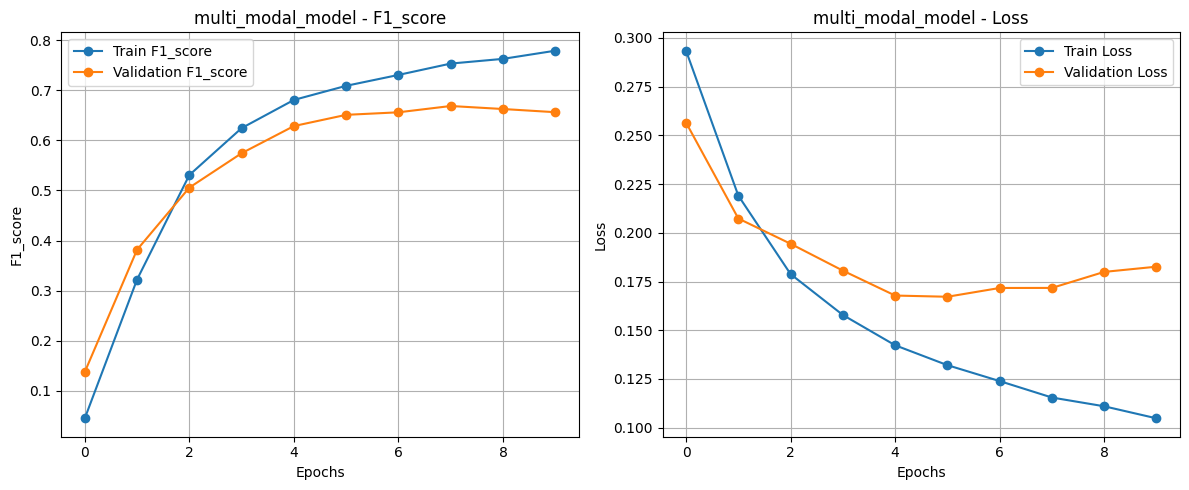

In [45]:
model_performance("multi_modal_model", multi_modal_model_history)

75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 780ms/step


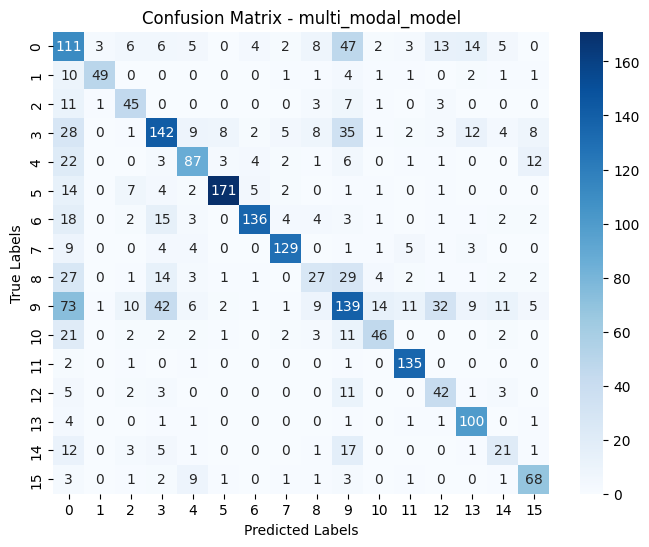

In [46]:
y_pred_multi = multi_modal_model.predict(test_ds)
y_pred_multi = (y_pred_multi > 0.5).astype(int)

plot_confusion_matrix(test_labels, y_pred_multi, "multi_modal_model")

###Comparaison des performances et choix du modèle final
  

Comparer les performances du modèle multimodal avec celles des modèles unimodaux (images seule, textes seul).

*Le modèle entrainé avec les caractéristiques unimodales : vgg2_model (carctéristiques visuelles) et hy_brid_lstm_cnn_model (caratéristiques textuelles) a de bonnes courbes d'apprentissage. Et prédit mieux les vrais positifs (diagonale) que les modèles vgg2_model et hybrid_lstm_cnn_model pendant le test.*

Justifier le choix du modèle final.

**Nous allons garder comme modèle final, le modèle entrainé avec les caractéristiques unimodales : final_model, car il fait moins d'erreur pendant le test que les autres modèles.**